In [1]:
from typing import Optional, List, Type, Tuple, Dict
import math

import numpy as np
from matplotlib import pyplot as plt

import torch.nn as nn
import torch.distributions as D
from sklearn.datasets import make_moons


from pathlib import Path
import torch
from torch import nn
# 1. Create models directory
PATH = Path.cwd()
NAME = 'generation_moons_unguided.pth'
SAVE_PATH = PATH /'models' / NAME
device = 'cuda' if torch.cuda.is_available() else 'cpu'


def duplicate_model(loaded_model):
# Create new instance of model and load saved state dict (make sure to put it on the target device)
    loaded_model.load_state_dict(torch.load(SAVE_PATH))
    loaded_model.to(device)
    return loaded_model




In [2]:
class FlowModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(3, 64), # Input is x (2D) + t (1D) = 3D
            nn.ReLU(),
            nn.Linear(64,64),
            nn.ReLU(),
            nn.Linear(64,64),
            nn.ReLU(),
            nn.Linear(64,64),
            nn.ReLU(),
            nn.Linear(64,2), # Output is 2D velocity vector
        )

    def forward(self, x , t):
        x_t = torch.cat((x, t),dim = 1)
        return self.layers(x_t)


In [3]:
model = FlowModel()
model = duplicate_model(model)

In [4]:
from tqdm import tqdm
#device agnostic
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# we define 2 classes for sample

class SampleMoons():
    '''make a batch of moons tensor'''

    def __init__(self,  scale=4):
        self.scale = scale

    def sample(self, num_samples):
        samples , _ = make_moons(num_samples, noise = 0.02 ,random_state = 42)
        return samples * self.scale

class SampleGaussian(torch.nn.Module):
    """
    Multivariate Gaussian distribution
    """
    def __init__(self, mean: torch.Tensor, cov: torch.Tensor):
        """
        mean: shape (dim,)
        cov: shape (dim,dim)
        """
        super().__init__()
        self.register_buffer("mean", mean)
        self.register_buffer("cov", cov)

    @property
    def dim(self) -> int:
        return self.mean.shape[0]

    @property
    def distribution(self):
        return D.MultivariateNormal(self.mean, self.cov, validate_args=False)

    def sample(self, num_samples) -> torch.Tensor:
        return self.distribution.sample((num_samples,))


    @classmethod
    def isotropic(cls, dim: int =2, std: float =1.0) -> "SampleGaussian": # Changed return type to SampleGaussian
        mean = torch.zeros(dim)
        cov = torch.eye(dim) * std ** 2
        return cls(mean, cov)

# create the simulator and the path
class Path:
    """
    the design path tells position and velocity at any time.
    here I choose linear path for simplicity
    """

    def __init__(self,img_type):
        self.p_simple = SampleGaussian.isotropic(dim=2, std=2.0)
        self.p_data = img_type

    def sample_condition_variable(self, num_samples):
        z = torch.from_numpy(self.p_data.sample(num_samples)).type(torch.float)
        return z

    # MODIFIED: Now returns both x_t and the sampled x_init
    def conditional_path(self, z: torch.Tensor, t: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """specific position and initial noise"""
        x_init = self.p_simple.sample(z.shape[0]).to(device).type(torch.float)
        x_t = (torch.ones_like(t)-t) * x_init + t * z
        return x_t, x_init # Return both x_t and x_init

    # MODIFIED: Corrected reference velocity field. It should be z - x_init.
    # x and t are not needed as inputs for the true linear path velocity.
    def conditional_v_field(self, z: torch.Tensor, x_init: torch.Tensor) -> torch.Tensor:
        """The true conditional velocity field for a linear path."""
        return z - x_init


class LearnedVectorFieldODE:
    def __init__(self, net):
        self.net = net

    def drift_coefficient(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Args:
            - x: (bs, dim)
            - t: (bs, 1)
        Returns:
            - u_t: (bs, dim)
        """
        return self.net(x, t)

class Simulator:
    """ODE euler simulator for integration"""
    def __init__(self, ode:LearnedVectorFieldODE, steps, path:Path):
        self.vector_field = ode# the ODE
        self.steps = steps
        self.path = path
    def step(self, x, t, h):

        return x + self.vector_field.drift_coefficient(x, t) * h

    def simulate(self,num_samples):
        ts = torch.linspace(0.0, 1.0, self.steps).to(device)
        dt = 1.0 / self.steps # CORRECTED: Use dt based on self.steps
        x = self.path.p_simple.sample(num_samples).to(device) # This is x_0
        for i_t in range(self.steps):
            t = ts[i_t].item() * torch.ones((x.shape[0],1)).to(device)
            x = self.step(x, t, dt) # CORRECTED: Use dt here
        return x



    def simulate_with_trajectory(self, num_samples):
        """
        Returns trajectory for all samples over time.

        Returns:
            xs: Tensor of shape (num_samples, num_steps + 1, 2)
        """
        dt = 1.0 / self.steps
        x = self.path.p_simple.sample(num_samples).to(device)  # Initial x0
        ts = torch.linspace(0.0, 1.0, self.steps).to(device)
        xs = [x.clone()]

        for t_val in tqdm(ts, desc="Simulating trajectory"):
            t = torch.full((x.shape[0], 1), t_val.item()).to(device)
            x = self.step(x, t, dt)
            xs.append(x.clone())

        return torch.stack(xs, dim=1)  # (num_samples, steps+1, dim)



In [5]:
path = Path(SampleMoons())
velocity_field = LearnedVectorFieldODE(model)
simulator = Simulator(velocity_field,10,path) # 100 steps for simulation


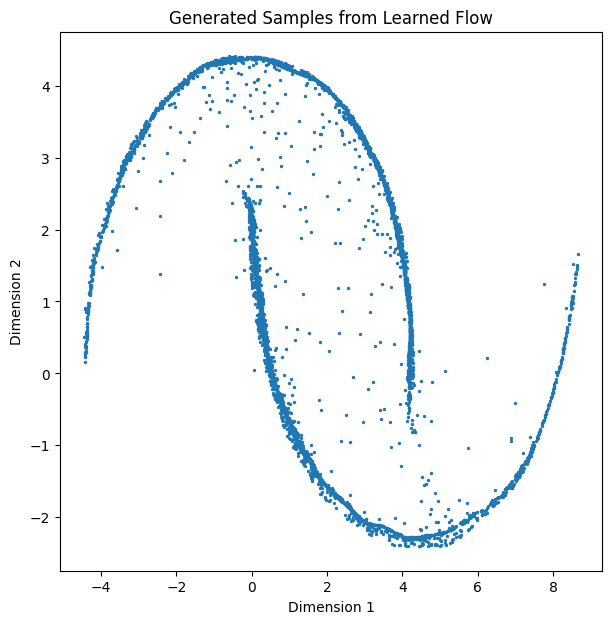

In [6]:

img = simulator.simulate(5000).cpu().detach().numpy() # 1000 samples for simulation output
x,y = (img[:,0] ,img[:,1])
fig,ax = plt.subplots(figsize = (7,7))
ax.scatter(x,y,s = 2)
ax.set_title("Generated Samples from Learned Flow")
ax.set_xlabel("Dimension 1")
ax.set_ylabel("Dimension 2")
plt.show() # Display the plot

In [7]:
def plot_trajectories(trajectories: torch.Tensor, num_plot: int = 100):
    """
    Plots the flow lines of multiple 2D particles over time.

    Args:
        trajectories: Tensor of shape (num_samples, steps+1, 2)
        num_plot: Number of trajectories to plot (for readability)
    """
    trajectories = trajectories.detach().cpu().numpy()
    num_samples = trajectories.shape[0]
    steps = trajectories.shape[1]

    plt.figure(figsize=(8, 8))
    for i in range(min(num_plot, num_samples)):
        traj = trajectories[i]
        plt.plot(traj[:, 0], traj[:, 1], alpha=0.5)
        plt.scatter(traj[0, 0], traj[0, 1], color='blue', s=10)  # Start
        plt.scatter(traj[-1, 0], traj[-1, 1], color='red', s=10)  # End

    plt.title("Particle Trajectories under Learned Flow")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.grid(True)
    plt.axis("equal")
    plt.show()


def compute_vector_field(vector_field: "LearnedVectorFieldODE", grid_size: int = 20, t_val: float = 0.5):
    x_range = torch.linspace(-4, 8, grid_size)
    y_range = torch.linspace(-4, 6, grid_size)
    xx, yy = torch.meshgrid(x_range, y_range, indexing='ij')
    mesh_points = torch.stack([xx.flatten(), yy.flatten()], dim=1).to(device)
    t = torch.full((mesh_points.size(0), 1), t_val).to(device)

    with torch.no_grad():
        vectors = (vector_field.drift_coefficient(mesh_points, t)).cpu()

    X, Y = mesh_points[:, 0].cpu().numpy(), mesh_points[:, 1].cpu().numpy()
    U, V = vectors[:, 0].numpy(), vectors[:, 1].numpy()
    return X, Y, U, V


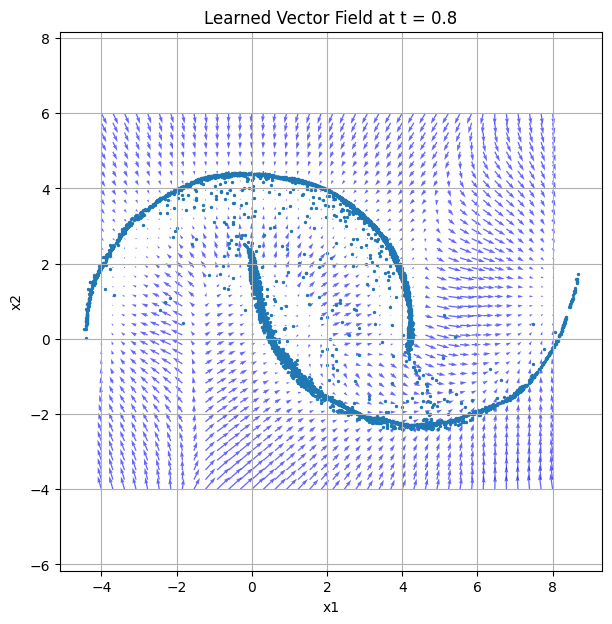

In [10]:
t_val = 0.8
X, Y, U, V = compute_vector_field(velocity_field, grid_size=40, t_val=t_val)
plt.figure(figsize=(7, 7))
plt.quiver(X, Y, U, V, color='blue', alpha=0.6)
plt.title(f"Learned Vector Field at t = {t_val}")
plt.xlabel("x1")
plt.ylabel("x2")
plt.grid(True)
plt.axis("equal")

img = simulator.simulate(5000).cpu().detach().numpy() # 1000 samples for simulation output
x,y = (img[:,0] ,img[:,1])
plt.scatter(x, y, s= 2)


plt.show()

Simulating trajectory: 100%|██████████| 10/10 [00:00<00:00, 2465.35it/s]


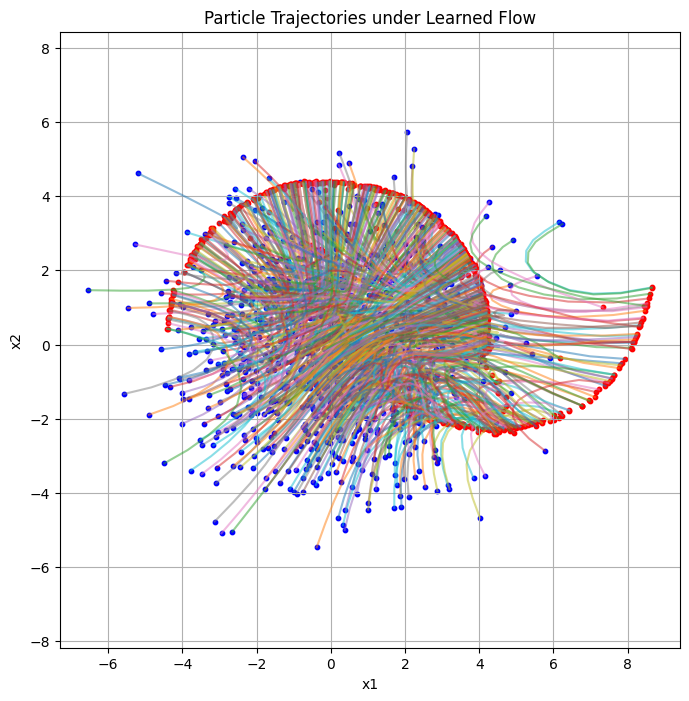

In [9]:
trajectories = simulator.simulate_with_trajectory(num_samples=5000)
plot_trajectories(trajectories, num_plot=1000)
